In [83]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr, probplot, shapiro, kstest, anderson

from statsmodels.formula.api import ols
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [84]:
origin=pd.read_excel('1사분위수_데이터.xlsx')
df=origin.drop('Unnamed: 0', axis=1)
df.head()

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0


In [85]:
def ols_report(tbl, data):
    xnames=[n for n in fit.model.exog_names if n!='const']
    indi_mydata1=data.filter(xnames)
    variables=[]
    for i, v in enumerate(tbl.tables[1].data):
        name=v[0].strip()
        if name not in xnames:
            continue
        j=list(indi_mydata1.columns).index(name)
        vif=variance_inflation_factor(indi_mydata1,j)

        p=float(v[4].strip())
        stars=lambda p: (
            '***' if p<0.001 else
            '**' if p<0.01 else
            '*' if p<0.05 else
            ''
        )

        variables.append({
            '종속변수':yname,
            '독립변수':name,
            'B':v[1].strip(),
            '표준오차':v[2].strip(),
            'Beta':float(fit.params[name])*(data[name].std(ddof=1)/data[yname].std(ddof=1)),
            't':'%s%s'%(v[3].strip(), stars(p)),
            'p-value':p,
            '공차':1/vif,
            'vif':vif
        })

    rdf=DataFrame(variables)

    if rdf.empty:
        return None, "데이터 없음", "모델 유의하지 않음", []

    result_dict={}
    for i in [0,2]:
        for item in tbl.tables[i].data:
            n=len(item)
            for j in range(0, n, 2):
                key=item[j].strip()[:-1]
                value=item[j+1].strip()
                if not key or not value:
                    continue
                result_dict[key]=value
    
    result_report=f'R({result_dict['R-squared']}), R²({result_dict['Adj. R-squared']}), F({result_dict['F-statistic']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})'

    tpl='%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s)=%s, p %s 0.05).'
    model_report=tpl%(
        rdf['종속변수'][0],
        ','.join(list(rdf['독립변수'])),
        '유의하다' if float(result_dict['Prob (F-statistic)'])<=0.05 else '유의하지 않다',
        result_dict['Df Model'],
        result_dict['Df Residuals'],
        result_dict['F-statistic'],
        '<=' if float(result_dict['Prob (F-statistic)'])<=0.05 else '>'
    )

    variable_reports=[]
    s='%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다.'

    for i in rdf.index:
        row=rdf.iloc[i]
        variable_reports.append(s%(row['독립변수'],
                                   row['B'],
                                   '<=' if float(row['p-value'])<0.05 else '>',
                                   row['종속변수'],
                                   '유의미한' if float(row['p-value'])<0.05 else '유의하지 않은'))
        
    return rdf, result_report, model_report, variable_reports

In [86]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.drop(['cut','color','clarity'], axis=1)
x=mydata1.drop(yname, axis=1)
y=mydata1[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata1)
print('=== 1차 회귀분석 ===')
display(rdf)

=== 1차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,418.2261,177.342,0.139142,2.358*,0.018,0.000535,1870.038224
1,price,x,712.1382,36.146,1.049620,19.702***,0.000,0.000079,12623.340831
2,price,y,-1268.6392,54.634,-1.868168,-23.221***,0.000,0.000072,13923.200928
3,price,z,1269.4950,97.301,1.191316,13.047***,0.000,0.000037,26980.367784
4,price,depth,-64.9594,4.759,-0.501661,-13.650***,0.000,0.000099,10057.396023
5,price,table,-7.9740,0.649,-0.111636,-12.286***,0.000,0.001115,896.727561


> vif 값이 가장 높은 z를 제외하고 다시 분석

In [87]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.drop(['z','cut','color','clarity'], axis=1)
x=mydata1.drop(yname, axis=1)
y=mydata1[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata1)
print('=== 2차 회귀분석 ===')
display(rdf)

=== 2차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,435.4938,178.453,0.144887,2.440*,0.015,0.002625,380.945858
1,price,x,937.4507,31.953,1.381708,29.338***,0.000,0.000079,12617.944299
2,price,y,-712.2624,34.367,-1.048861,-20.725***,0.000,0.000087,11533.773835
3,price,depth,-7.4140,1.798,-0.057256,-4.123***,0.000,0.000982,1017.889284
4,price,table,-7.4878,0.652,-0.104829,-11.483***,0.000,0.001537,650.626360


> vif 값이 가장 높은 x를 제외하고 다시 분석

In [88]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.filter(['price','carat','y','depth','table'])
x=mydata1.drop(yname, axis=1)
y=mydata1[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata1)
print('=== 3차 회귀분석 ===')
display(rdf)

=== 3차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,3430.9795,150.976,1.141469,22.725***,0.0,0.002922,342.277100
1,price,y,-462.6659,34.348,-0.681311,-13.470***,0.0,0.000370,2705.743403
2,price,depth,-29.9997,1.676,-0.231679,-17.896***,0.0,0.001024,976.634711
3,price,table,-11.1659,0.660,-0.156323,-16.916***,0.0,0.001620,617.237197


> vif 값이 가장 높은 y를 제외하고 다시 분석

In [89]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.filter(['price','carat','depth','table'])
x=mydata1.drop(yname, axis=1)
y=mydata1[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata1)
print('=== 4차 회귀분석 ===')
display(rdf)

=== 4차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1420.3619,22.807,0.472547,62.278***,0.0,0.021959,45.539408
1,price,depth,-12.4372,1.061,-0.096049,-11.726***,0.0,0.002071,482.879830
2,price,table,-6.9298,0.584,-0.097018,-11.861***,0.0,0.002193,456.017822


> vif 값이 가장 높은 depth를 제외하고 다시 분석

In [90]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.filter(['price','carat','table'])
x=mydata1.drop(yname, axis=1)
y=mydata1[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata1)
print('=== 5차 회귀분석 ===')
display(rdf)

=== 5차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1405.3487,22.886,0.467552,61.406***,0.0,0.023342,42.840456
1,price,table,-4.3465,0.544,-0.060852,-7.992***,0.0,0.023342,42.840456


> carat과 table 모두 vif값은 동일하나, carat의 t값이 더 크기에 table을 제거 후 다시 분석

In [91]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.filter(['price','carat'])
x=mydata1.drop(yname, axis=1)
y=mydata1[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
print('=== 6차 회귀분석 ===')
display(tbl1)

=== 6차 회귀분석 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     3756.
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:41:45   Log-Likelihood:                -84508.
No. Observations:               13414   AIC:                         1.690e+05
Df Residuals:                   13412   BIC:                         1.690e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        222.2427      7.672     28.968      0.000     207.204     237.281
carat       1405.9612     22.940     61.289      0.000    1360.996    1450.926
==============================================================================
Omnibus:                      783.551   Durbin-Watson:                   0.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              299.587
Skew:                           0.070   Prob(JB):                     8.82e-66
Kurtosis:                       2.281   Cond. No.                         22.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> 명목형 변수들을 다시 넣은 후 회귀분석 진행

In [92]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.filter(['price','carat','cut','color','clarity'])
mydata2=pd.get_dummies(mydata1, drop_first=True)
mydata2=mydata2.astype(float)
x=mydata2.drop(yname, axis=1)
y=mydata2[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata2)
print('=== 7차 회귀분석 ===')
display(rdf)

=== 7차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2369.6077,16.399,0.788356,144.495***,0.000,0.022835,43.792753
1,price,cut_Good,0.2244,9.369,0.000405,0.024,0.981,0.092906,10.763592
2,price,cut_Ideal,55.8046,9.096,0.186729,6.135***,0.000,0.016777,59.604330
3,price,cut_Premium,85.7268,9.156,0.236522,9.363***,0.000,0.035919,27.840331
4,price,cut_Very Good,2.6157,9.157,0.007415,0.286,0.775,0.033277,30.050512
5,price,color_E,-28.8420,2.493,-0.078330,-11.569***,0.000,0.396508,2.522020
6,price,color_F,-49.6388,2.634,-0.124642,-18.847***,0.000,0.435747,2.294912
7,price,color_G,-84.0879,2.538,-0.232261,-33.125***,0.000,0.362434,2.759121
8,price,color_H,-139.0340,2.728,-0.332779,-50.970***,0.000,0.453419,2.205466
9,price,color_I,-206.2285,3.160,-0.392256,-65.265***,0.000,0.572930,1.745413


> cut_Good과 cut_Very Good의 p-value 값이 0.05보다 크기 때문에 제거 후 다시 분석

In [93]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.filter(['price','carat','cut','color','clarity'])
mydata2=pd.get_dummies(mydata1, drop_first=True)
mydata2=mydata2.astype(float)
mydata3=mydata2.drop(['cut_Good', 'cut_Very Good'], axis=1)
x=mydata3.drop(yname, axis=1)
y=mydata3[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata3)
print('=== 8차 회귀분석 ===')
display(rdf)

=== 8차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2368.9413,16.350,0.788135,144.894***,0.0,0.024149,41.410351
1,price,cut_Ideal,53.8250,1.660,0.180105,32.426***,0.0,0.392725,2.546313
2,price,cut_Premium,83.7727,2.005,0.231130,41.776***,0.0,0.583015,1.715223
3,price,color_E,-28.8466,2.493,-0.078343,-11.572***,0.0,0.397088,2.518336
4,price,color_F,-49.6651,2.633,-0.124708,-18.866***,0.0,0.435953,2.293826
5,price,color_G,-84.0809,2.538,-0.232242,-33.125***,0.0,0.362574,2.758061
6,price,color_H,-139.0692,2.727,-0.332863,-50.994***,0.0,0.453915,2.203057
7,price,color_I,-206.2861,3.159,-0.392365,-65.306***,0.0,0.573263,1.744400
8,price,color_J,-276.4080,4.560,-0.324366,-60.616***,0.0,0.768628,1.301019
9,price,clarity_IF,550.1275,11.942,0.768774,46.067***,0.0,0.356608,2.804203


📕 선형성 검정
RESET F-statistic: 14.9890
p-value: 0.0001
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


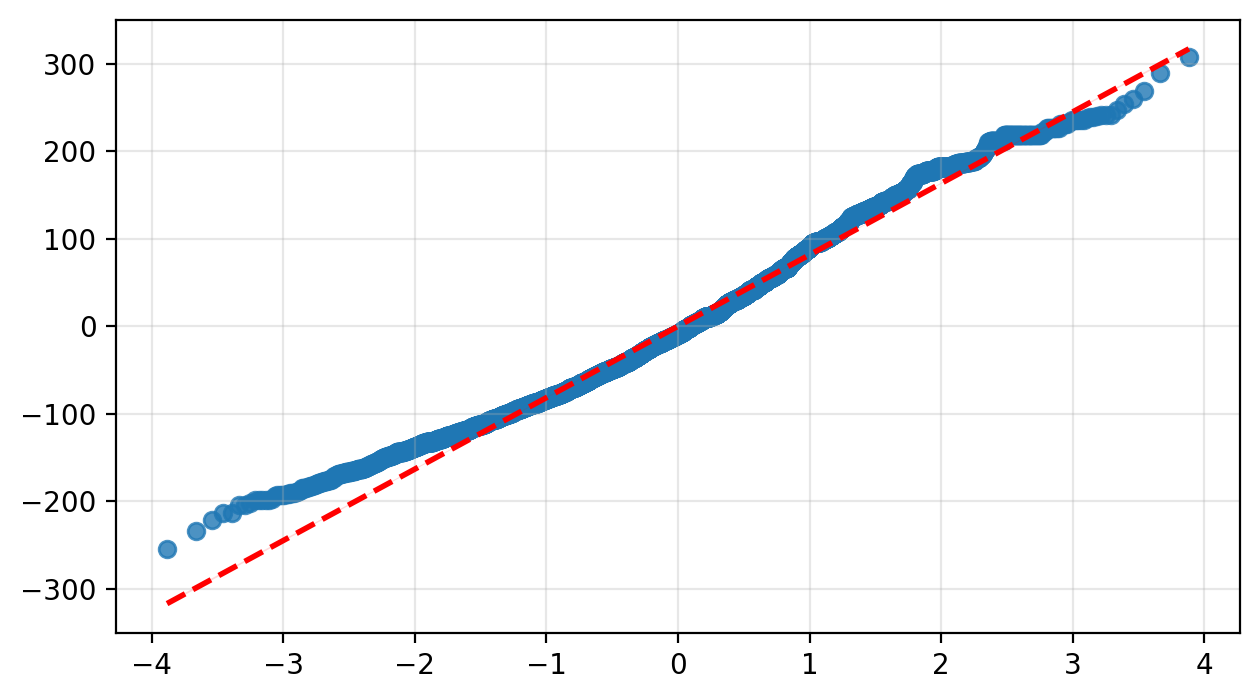

루트 1MSE 구간에 포함된 잔차 비율: 66.27%
루트 2MSE 구간에 포함된 잔차 비율: 95.51%
루트 3MSE 구간에 포함된 잔차 비율: 99.95%


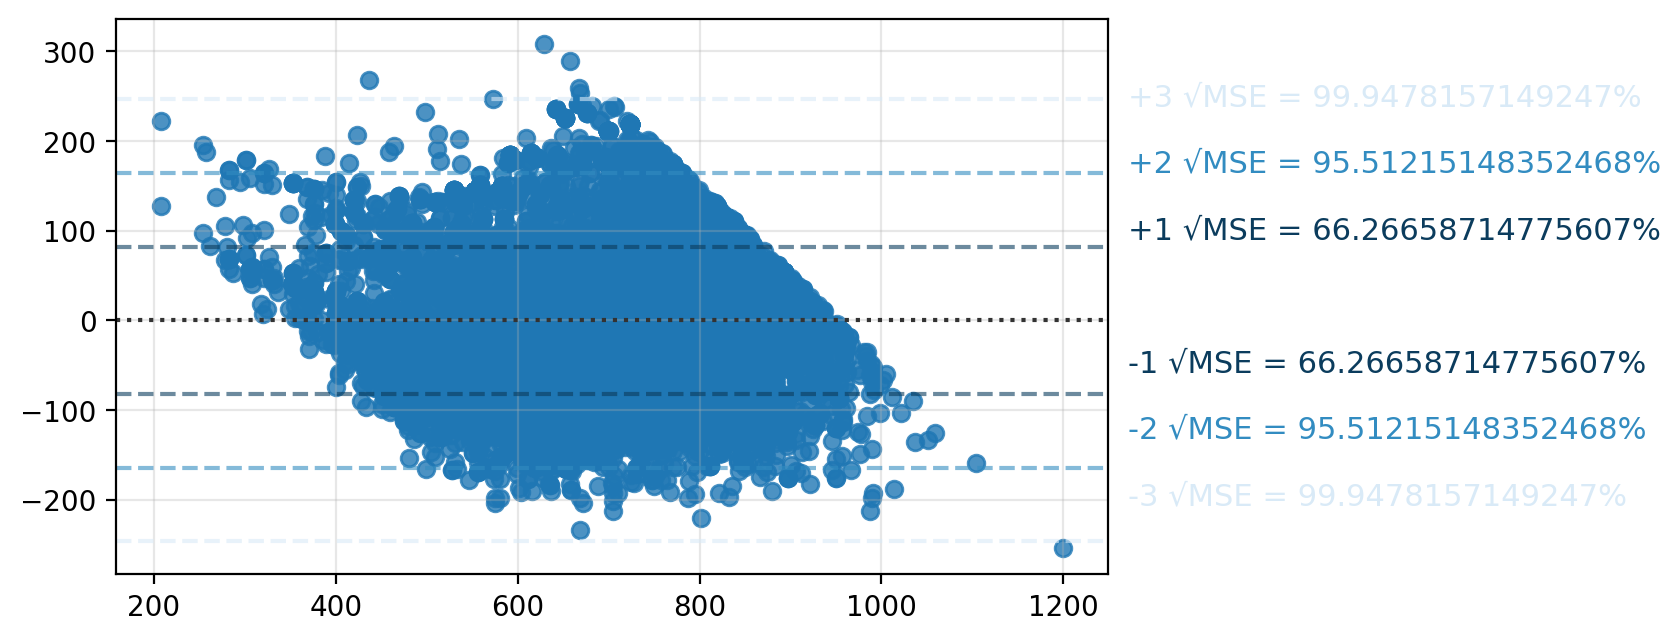

🎯 잔차의 정규성, 등분산성, 독립성 검정
Anderson-Darling statistic: 60.5857, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)
Breusch-Pagan statistic: 22.376, p-value = 0.000
이분산성 존재(등분산 아님)
Durbin-Watson=0.571
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)
🎓 최종 결과 보고
price에 대하여 carat,cut_Ideal,cut_Premium,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(16,13397)=1917., p <= 0.05).
carat의 회귀계수는 2368.9413(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Ideal의 회귀계수는 53.8250(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 83.7727(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 -28.8466(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 -49.6651(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_G의 회귀계수는 -84.0809(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_H의 회귀계수는 -139.0692(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_I의 회귀계수는 -206.2861(p <= 0.05)

In [94]:
# 잔차 검정
print('='*50)
print('📕 선형성 검정')
print('='*50)
reset_res=linear_reset(fit, power=2, use_f=True)
print(f'RESET F-statistic: {reset_res.fvalue:.4f}')
print(f'p-value: {reset_res.pvalue:.4f}')
if reset_res.pvalue<0.05:
    print('선형성/기능형 위배 가능성이 있음 (5% 유의수준)')
else:
    print('선형성 가정 위배 근거 없음 (5% 유의수준)')

(x,y),_=probplot(fit.resid)
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.regplot(x=x, y=y, line_kws={'color':'red', 'linestyle':'--', 'linewidth':2})
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

r=fit.resid
mse_sq=fit.mse_resid
mse_root=np.sqrt(mse_sq)
colors=['#0B3C5D', '#328CC1', '#D9EAF7']
r1=r[(r>-mse_root)&(r<mse_root)].count()/r.count()*100
r2=r[(r>-2*mse_root)&(r<2*mse_root)].count()/r.count()*100
r3=r[(r>-3*mse_root)&(r<3*mse_root)].count()/r.count()*100
mse_r=[r1,r2,r3]
print(f'루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%')
print(f'루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%')
print(f'루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%')
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.residplot(x=fit.fittedvalues, y=fit.resid)
ax.grid(True, alpha=0.3)
for i, c in enumerate(colors):
    k=i+1
    y_pos=k*mse_root
    ax.axhline(y=y_pos, color=c, linestyle='--', alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle='--', alpha=0.6)
    ax.text(x=1.02, y=0.5+0.12*k,
            s=f'+{k} √MSE = {mse_r[i]}%',
            transform=ax.transAxes,
            ha='left', va='center', fontsize=11, color=c)
    ax.text(x=1.02, y=0.5-0.12*k,
            s=f'-{k} √MSE = {mse_r[i]}%',
            transform=ax.transAxes,
            ha='left', va='center', fontsize=11, color=c)
plt.show()
plt.close()

# 잔차의 정규성, 등분산성, 독립성 검정
print('='*50)
print('🎯 잔차의 정규성, 등분산성, 독립성 검정')
print('='*50)
if len(origin)<5000:
    method='Shapiro-Wilk'
    s, p=shapiro(fit.resid)
    print(f'{method} statistic: {s:.4f}, p-value: {p:.4f}')
    violated=p<0.05
else:
    method='Anderson-Darling'
    ad_res=anderson(fit.resid, dist='norm')
    crit_levels=ad_res.significance_level.tolist()
    crit_values=ad_res.critical_values.tolist()
    crit_5=crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f'{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}')
    violated=crit_5 is not None and ad_res.statistic>crit_5
print('정규성 가정 위배 가능성이 있음 (5% 유의수준)' if violated else '정규성 가정 위배 근거 없음 (5% 유의수준)')

names=['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test=het_breuschpagan(fit.resid, fit.model.exog)
bp=DataFrame(bp_test, index=names, columns=['value'])
p_bp=bp.loc['F p-value', 'value']
print(f'Breusch-Pagan statistic: {bp.loc['F Statistic', 'value']:.3f}, p-value = {p_bp:.3f}')
print(f'{'이분산성 존재(등분산 아님)' if p_bp<=0.05 else '등분산성 만족'}')

dw=durbin_watson(fit.resid)
if 1.5<=dw<=2.5:
    interpretation='잔차는 독립성을 만족함 (자기상관 없음)'
elif dw<1.5:
    interpretation='잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)'
else:
    interpretation='잔차에 음(-)의 자기상관이 존재할 가능성 있음 (독립성 위반)'
print(f'Durbin-Watson={dw:.3f}\n{interpretation}')

# 최종 결과 보고
print('='*50)
print('🎓 최종 결과 보고')
print('='*50)
print(m)
print('\n'.join(v))

⭐⭐⭐ 아래는 더미변수 모두 넣고 vif, p-value 이상치만 제거한 회귀분석 ⭐⭐⭐

In [95]:
mydata=df
yname='price'
mydata1=mydata.copy()

mydata2=pd.get_dummies(mydata1, drop_first=True)
mydata2=mydata2.astype(float)
x=mydata2.drop(yname, axis=1)
y=mydata2[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata2)
print('=== 1차 회귀분석 ===')
display(rdf)
count=2

while True:
    if rdf['vif'].max()>=10:
        mydata2=mydata2.drop(rdf[rdf['vif']==rdf['vif'].max()]['독립변수'], axis=1)
        x=mydata2.drop(yname, axis=1)
        y=mydata2[yname]
        x_input=sm.add_constant(x)
        fit=sm.OLS(y, x_input).fit()
        tbl=fit.summary()
        rdf, r, m, v=ols_report(tbl, mydata2)
        print('=== %s차 회귀분석 ==='%count)
        display(rdf)
        count+=1
    else:
        print('***'*30)
        print('*** vif 10 이상 제거 완료 ***')
        print('***'*30)
        break

print('#'*50)
print('p-value 무효값을 제외한 최종 모델')
print('#'*50)
# p-value 무효값 제외
xnames=list(rdf[rdf['p-value']>0.05]['독립변수'])
mydata2=mydata2.drop(xnames, axis=1)
x=mydata2.drop(yname, axis=1)
y=mydata2[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl=fit.summary()
rdf, r, m, v=ols_report(tbl, mydata2)
display(rdf)

=== 1차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1763.6548,96.262,0.586759,18.321***,0.000,0.000495,2019.086748
1,price,x,875.6868,19.333,1.290674,45.295***,0.000,0.000071,14090.534481
2,price,y,-1906.6859,30.629,-2.807741,-62.251***,0.000,0.000057,17477.337675
3,price,z,1934.4775,52.342,1.815347,36.958***,0.000,0.000035,28625.758032
4,price,depth,-78.3710,2.590,-0.605235,-30.265***,0.000,0.000093,10788.497731
5,price,table,-0.6704,0.416,-0.009386,-1.610,0.107,0.000708,1412.247221
6,price,cut_Good,85.3045,7.618,0.153957,11.197***,0.000,0.070822,14.120005
7,price,cut_Ideal,133.8864,7.566,0.448000,17.696***,0.000,0.012081,82.774018
8,price,cut_Premium,139.6400,7.464,0.385269,18.709***,0.000,0.026839,37.259664
9,price,cut_Very Good,100.8018,7.510,0.285746,13.423***,0.000,0.024555,40.725231


=== 2차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1721.9841,101.042,0.572895,17.042***,0.000,0.001624,615.908216
1,price,x,1184.9312,18.295,1.746469,64.768***,0.000,0.000071,14052.523895
2,price,y,-1015.7952,19.836,-1.495836,-51.211***,0.000,0.000072,13911.282948
3,price,depth,10.0505,1.040,0.077617,9.663***,0.000,0.000851,1175.057182
4,price,table,-0.2433,0.437,-0.003406,-0.557,0.578,0.000939,1065.198241
5,price,cut_Good,62.2060,7.970,0.112269,7.805***,0.000,0.071236,14.037912
6,price,cut_Ideal,116.9325,7.928,0.391270,14.750***,0.000,0.012239,81.707022
7,price,cut_Premium,129.2213,7.829,0.356524,16.505***,0.000,0.027013,37.019716
8,price,cut_Very Good,79.1525,7.859,0.224376,10.071***,0.000,0.024870,40.209116
9,price,color_E,-29.1626,2.093,-0.079201,-13.933***,0.000,0.392615,2.547027


=== 3차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,5273.5546,97.253,1.754485,54.225***,0.0,0.001743,573.650702
1,price,y,-660.6982,21.845,-0.972929,-30.245***,0.0,0.000230,4347.593323
2,price,depth,-16.7181,1.094,-0.129109,-15.286***,0.0,0.000909,1100.624546
3,price,table,-5.4811,0.492,-0.076735,-11.139***,0.0,0.000970,1030.558665
4,price,cut_Good,35.0162,9.121,0.063197,3.839***,0.0,0.071375,14.010421
5,price,cut_Ideal,93.0837,9.075,0.311469,10.257***,0.0,0.012239,81.706593
6,price,cut_Premium,120.2417,8.970,0.331749,13.404***,0.0,0.027025,37.002456
7,price,cut_Very Good,41.1183,8.981,0.116559,4.578***,0.0,0.024910,40.145241
8,price,color_E,-29.2245,2.398,-0.079369,-12.185***,0.0,0.392667,2.546688
9,price,color_F,-49.8596,2.533,-0.125197,-19.684***,0.0,0.431617,2.316866


=== 4차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2371.0741,16.302,0.788844,145.444***,0.000,0.017082,58.539930
1,price,depth,8.3287,0.738,0.064320,11.280***,0.000,0.001212,824.861648
2,price,table,-0.3648,0.478,-0.005108,-0.764,0.445,0.001455,687.296760
3,price,cut_Good,5.6062,9.373,0.010118,0.598,0.550,0.075602,13.227178
4,price,cut_Ideal,70.2504,9.347,0.235066,7.516***,0.000,0.013914,71.868011
5,price,cut_Premium,105.3248,9.257,0.290593,11.378***,0.000,0.029033,34.443036
6,price,cut_Very Good,17.6305,9.248,0.049978,1.907,0.057,0.027123,36.869651
7,price,color_E,-28.1653,2.479,-0.076493,-11.363***,0.000,0.392753,2.546131
8,price,color_F,-49.2501,2.618,-0.123666,-18.813***,0.000,0.431943,2.315122
9,price,color_G,-84.6092,2.523,-0.233701,-33.530***,0.000,0.361660,2.765025


=== 5차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2368.2852,16.377,0.787916,144.610***,0.000,0.018155,55.082127
1,price,table,-2.7125,0.432,-0.037975,-6.281***,0.000,0.003131,319.413368
2,price,cut_Good,-3.9192,9.379,-0.007073,-0.418,0.676,0.079836,12.525626
3,price,cut_Ideal,47.7117,9.174,0.159649,5.201***,0.000,0.014724,67.915280
4,price,cut_Premium,86.1839,9.143,0.237783,9.426***,0.000,0.029545,33.846327
5,price,cut_Very Good,-0.1830,9.155,-0.000519,-0.020,0.984,0.028058,35.639895
6,price,color_E,-28.4946,2.490,-0.077387,-11.443***,0.000,0.392952,2.544843
7,price,color_F,-49.6519,2.630,-0.124675,-18.879***,0.000,0.432641,2.311387
8,price,color_G,-84.3330,2.535,-0.232938,-33.266***,0.000,0.362129,2.761444
9,price,color_H,-139.4070,2.725,-0.333672,-51.168***,0.000,0.453187,2.206597


=== 6차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2369.6077,16.399,0.788356,144.495***,0.000,0.022835,43.792753
1,price,cut_Good,0.2244,9.369,0.000405,0.024,0.981,0.092906,10.763592
2,price,cut_Ideal,55.8046,9.096,0.186729,6.135***,0.000,0.016777,59.604330
3,price,cut_Premium,85.7268,9.156,0.236522,9.363***,0.000,0.035919,27.840331
4,price,cut_Very Good,2.6157,9.157,0.007415,0.286,0.775,0.033277,30.050512
5,price,color_E,-28.8420,2.493,-0.078330,-11.569***,0.000,0.396508,2.522020
6,price,color_F,-49.6388,2.634,-0.124642,-18.847***,0.000,0.435747,2.294912
7,price,color_G,-84.0879,2.538,-0.232261,-33.125***,0.000,0.362434,2.759121
8,price,color_H,-139.0340,2.728,-0.332779,-50.970***,0.000,0.453419,2.205466
9,price,color_I,-206.2285,3.160,-0.392256,-65.265***,0.000,0.572930,1.745413


=== 7차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2363.5495,16.392,0.786341,144.191***,0.0,0.024235,41.262395
1,price,cut_Good,-54.6857,2.774,-0.098696,-19.714***,0.0,0.838564,1.192515
2,price,cut_Premium,30.7454,1.880,0.084827,16.358***,0.0,0.667148,1.498918
3,price,cut_Very Good,-52.4409,1.824,-0.148656,-28.751***,0.0,0.656304,1.523684
4,price,color_E,-29.1211,2.496,-0.079089,-11.667***,0.0,0.396893,2.519574
5,price,color_F,-50.1724,2.636,-0.125982,-19.034***,0.0,0.435848,2.294378
6,price,color_G,-84.1668,2.542,-0.232479,-33.112***,0.0,0.362541,2.758306
7,price,color_H,-138.9680,2.731,-0.332621,-50.877***,0.0,0.453714,2.204033
8,price,color_I,-206.1229,3.164,-0.392055,-65.144***,0.0,0.572940,1.745382
9,price,color_J,-276.2329,4.567,-0.324161,-60.479***,0.0,0.768461,1.301303


=== 8차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,cut_Good,-59.8721,4.431,-0.108057,-13.512***,0.000,0.838778,1.192210
1,price,cut_Premium,21.4518,3.001,0.059186,7.149***,0.000,0.667173,1.498861
2,price,cut_Very Good,-70.8882,2.907,-0.200949,-24.389***,0.000,0.657250,1.521492
3,price,color_E,-19.0849,3.986,-0.051832,-4.788***,0.000,0.400941,2.494133
4,price,color_F,-26.9860,4.203,-0.067761,-6.421***,0.000,0.444115,2.251667
5,price,color_G,-40.2093,4.031,-0.111063,-9.974***,0.000,0.373949,2.674165
6,price,color_H,-102.1892,4.344,-0.244591,-23.523***,0.000,0.463221,2.158799
7,price,color_I,-139.1410,5.000,-0.264652,-27.830***,0.000,0.591102,1.691756
8,price,color_J,-157.2074,7.176,-0.184484,-21.907***,0.000,0.797236,1.254333
9,price,clarity_IF,175.6873,18.585,0.245514,9.453***,0.000,0.705420,1.417595


******************************************************************************************
*** vif 10 이상 제거 완료 ***
******************************************************************************************
##################################################
p-value 무효값을 제외한 최종 모델
##################################################


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,cut_Good,-59.8728,4.431,-0.108058,-13.513***,0.0,0.879522,1.136982
1,price,cut_Premium,21.4501,3.000,0.059181,7.149***,0.0,0.715410,1.397799
2,price,cut_Very Good,-70.8832,2.906,-0.200935,-24.393***,0.0,0.709740,1.408967
3,price,color_E,-19.0906,3.985,-0.051847,-4.790***,0.0,0.590265,1.694154
4,price,color_F,-27.0000,4.199,-0.067797,-6.430***,0.0,0.614954,1.626137
5,price,color_G,-40.2152,4.030,-0.111079,-9.978***,0.0,0.535509,1.867382
6,price,color_H,-102.1917,4.344,-0.244597,-23.525***,0.0,0.634640,1.575697
7,price,color_I,-139.1403,5.000,-0.264651,-27.830***,0.0,0.748602,1.335824
8,price,color_J,-157.2113,7.176,-0.184488,-21.909***,0.0,0.878237,1.138644
9,price,clarity_IF,174.2423,6.026,0.243494,28.913***,0.0,0.822709,1.215497


📕 선형성 검정
RESET F-statistic: 67.3781
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


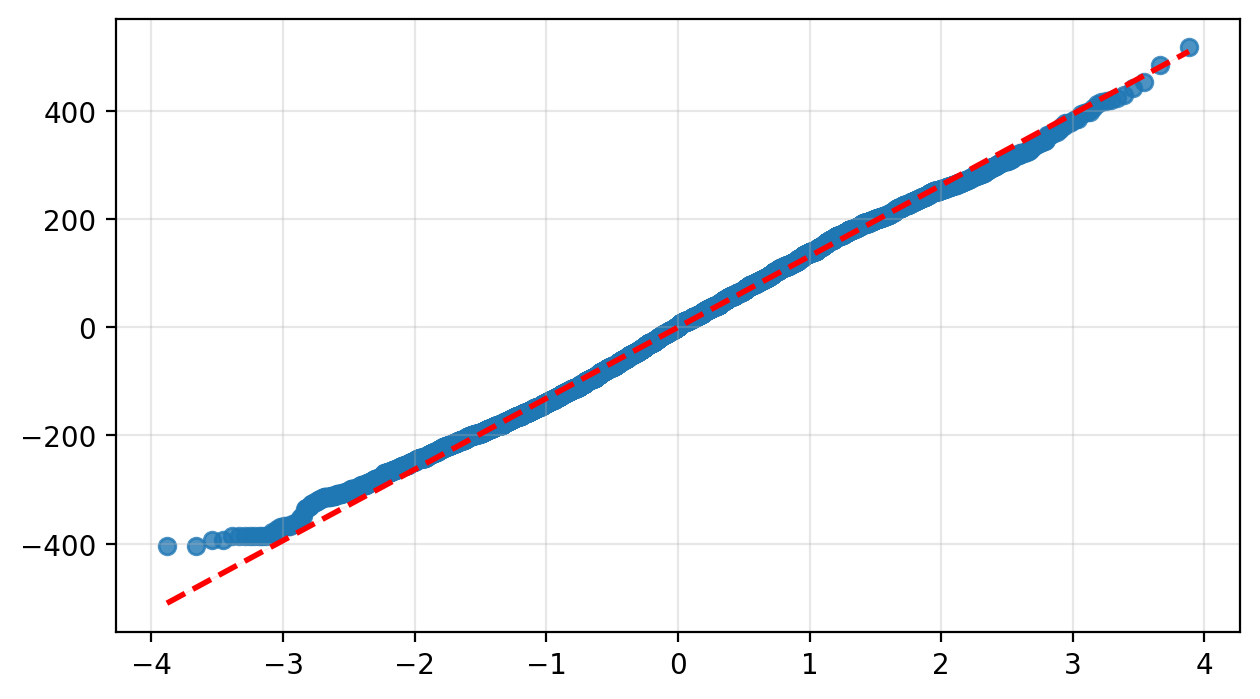

루트 1MSE 구간에 포함된 잔차 비율: 65.44%
루트 2MSE 구간에 포함된 잔차 비율: 96.70%
루트 3MSE 구간에 포함된 잔차 비율: 99.87%


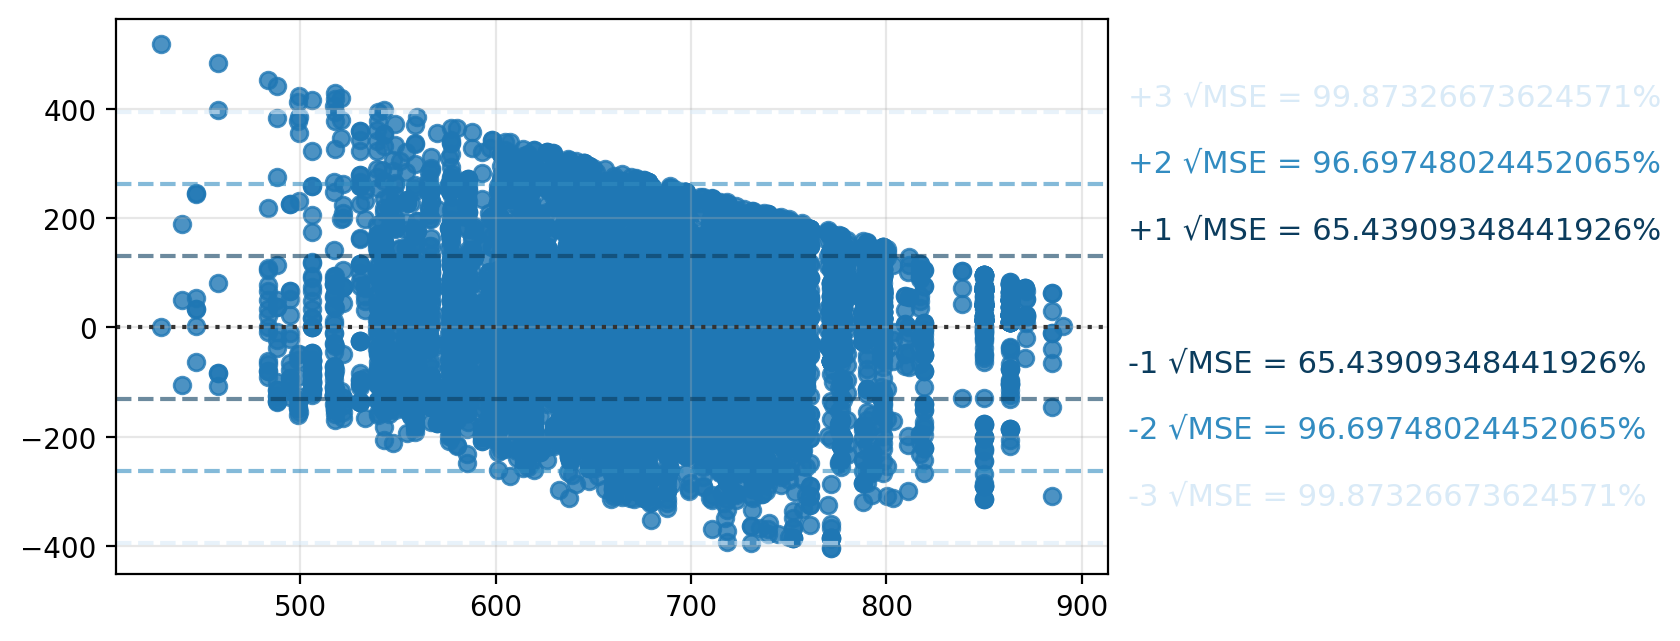

🎯 잔차의 정규성, 등분산성, 독립성 검정
Anderson-Darling statistic: 11.2418, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)
Breusch-Pagan statistic: 27.020, p-value = 0.000
이분산성 존재(등분산 아님)
Durbin-Watson=0.267
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)
🎓 최종 결과 보고
price에 대하여 cut_Good,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(15,13398)=254.8, p <= 0.05).
cut_Good의 회귀계수는 -59.8728(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 21.4501(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Very Good의 회귀계수는 -70.8832(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 -19.0906(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 -27.0000(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_G의 회귀계수는 -40.2152(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_H의 회귀계수는 -102.1917(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_I의 회귀계수는 -139.1403(p <= 0.0

In [96]:
# 잔차 검정
print('='*50)
print('📕 선형성 검정')
print('='*50)
reset_res=linear_reset(fit, power=2, use_f=True)
print(f'RESET F-statistic: {reset_res.fvalue:.4f}')
print(f'p-value: {reset_res.pvalue:.4f}')
if reset_res.pvalue<0.05:
    print('선형성/기능형 위배 가능성이 있음 (5% 유의수준)')
else:
    print('선형성 가정 위배 근거 없음 (5% 유의수준)')

(x,y),_=probplot(fit.resid)
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.regplot(x=x, y=y, line_kws={'color':'red', 'linestyle':'--', 'linewidth':2})
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

r=fit.resid
mse_sq=fit.mse_resid
mse_root=np.sqrt(mse_sq)
colors=['#0B3C5D', '#328CC1', '#D9EAF7']
r1=r[(r>-mse_root)&(r<mse_root)].count()/r.count()*100
r2=r[(r>-2*mse_root)&(r<2*mse_root)].count()/r.count()*100
r3=r[(r>-3*mse_root)&(r<3*mse_root)].count()/r.count()*100
mse_r=[r1,r2,r3]
print(f'루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%')
print(f'루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%')
print(f'루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%')
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.residplot(x=fit.fittedvalues, y=fit.resid)
ax.grid(True, alpha=0.3)
for i, c in enumerate(colors):
    k=i+1
    y_pos=k*mse_root
    ax.axhline(y=y_pos, color=c, linestyle='--', alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle='--', alpha=0.6)
    ax.text(x=1.02, y=0.5+0.12*k,
            s=f'+{k} √MSE = {mse_r[i]}%',
            transform=ax.transAxes,
            ha='left', va='center', fontsize=11, color=c)
    ax.text(x=1.02, y=0.5-0.12*k,
            s=f'-{k} √MSE = {mse_r[i]}%',
            transform=ax.transAxes,
            ha='left', va='center', fontsize=11, color=c)
plt.show()
plt.close()

# 잔차의 정규성, 등분산성, 독립성 검정
print('='*50)
print('🎯 잔차의 정규성, 등분산성, 독립성 검정')
print('='*50)
if len(origin)<5000:
    method='Shapiro-Wilk'
    s, p=shapiro(fit.resid)
    print(f'{method} statistic: {s:.4f}, p-value: {p:.4f}')
    violated=p<0.05
else:
    method='Anderson-Darling'
    ad_res=anderson(fit.resid, dist='norm')
    crit_levels=ad_res.significance_level.tolist()
    crit_values=ad_res.critical_values.tolist()
    crit_5=crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f'{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}')
    violated=crit_5 is not None and ad_res.statistic>crit_5
print('정규성 가정 위배 가능성이 있음 (5% 유의수준)' if violated else '정규성 가정 위배 근거 없음 (5% 유의수준)')

names=['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test=het_breuschpagan(fit.resid, fit.model.exog)
bp=DataFrame(bp_test, index=names, columns=['value'])
p_bp=bp.loc['F p-value', 'value']
print(f'Breusch-Pagan statistic: {bp.loc['F Statistic', 'value']:.3f}, p-value = {p_bp:.3f}')
print(f'{'이분산성 존재(등분산 아님)' if p_bp<=0.05 else '등분산성 만족'}')

dw=durbin_watson(fit.resid)
if 1.5<=dw<=2.5:
    interpretation='잔차는 독립성을 만족함 (자기상관 없음)'
elif dw<1.5:
    interpretation='잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)'
else:
    interpretation='잔차에 음(-)의 자기상관이 존재할 가능성 있음 (독립성 위반)'
print(f'Durbin-Watson={dw:.3f}\n{interpretation}')

# 최종 결과 보고
print('='*50)
print('🎓 최종 결과 보고')
print('='*50)
print(m)
print('\n'.join(v))